In [1]:
!which ipython

/home/rio/miniconda3/envs/multibind/bin/ipython


In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '/mnt/c/Users/ignacio.ibarra/Dropbox/annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [6]:
data = bd.bindome.datasets.SELEX.get_data()
# data[data['cycle'] == 'AF']
data

cardiac_complexes
# filenames 22
PRJEB14744
# filenames 12
PRJEB20112
# filenames 46
PRJEB3289
# filenames 68
PRJEB9797
# filenames 184


filename       library batch cycle    tf.name  \
0        GATA4TBX5_R1_R46_016_999.txt.gz           R46   R46   R46  GATA4TBX5   
1        GATA4TBX5_R2_R46_033_999.txt.gz           R46   R46   R46  GATA4TBX5   
2        GATA4TBX5_R3_R46_051_999.txt.gz           R46   R46   R46  GATA4TBX5   
3            GATA4_R1_R46_032_777.txt.gz           R46   R46   R46      GATA4   
4            GATA4_R2_R46_046_777.txt.gz           R46   R46   R46      GATA4   
..                                   ...           ...   ...   ...        ...   
327  FOXA1_FL_2_KX_TCCCAT40NTGT.fastq.gz  TCCCAT40NTGT    FL     2      FOXA1   
328  FOXA1_FL_3_KX_TAGCGT40NTCA.fastq.gz  TAGCGT40NTCA    FL     3      FOXA1   
329  FOXA1_FL_3_KX_TCCCAT40NTGT.fastq.gz  TCCCAT40NTGT    FL     3      FOXA1   
330  FOXA1_FL_4_KX_TAGCGT40NTCA.fastq.gz  TAGCGT40NTCA    FL     4      FOXA1   
331  FOXA1_FL_4_KX_TCCCAT40NTGT.fastq.gz  TCCCAT40NTGT    FL     4      FOXA1   

             accession  
0    cardiac_complexes  
1    cardiac_complexes  
2    cardiac_complexes  
3    cardiac_complexes  
4    cardiac_complexes  
..                 ...  
327          PRJEB9797  
328          PRJEB9797  
329          PRJEB9797  
330          PRJEB9797  
331          PRJEB9797  

[332 rows x 6 columns]

All TF's, using subsets of only round 0 and 1

In [10]:
# %time np.array([mb.tl.onehot_mononuc(row['seq'], le, oe) for index, row in next_data.head(10000).iterrows()]).shape

In [11]:
# %time next_data.head(10000)['seq'].apply(mb.tl.onehot_mononuc, args=(le, oe)) # (row['seq'], le, oe) for index, row in next_data.head(10).iterrows()])

In [12]:
import copy

ETS1
4 2
loading ETS1 : TGTAAA20NGA
dict_keys(['ETS1_TGTAAA20NGA_AF_1', 'ETS1_TGTAAA20NGA_AF_2', 'ETS1_TGTAAA20NGA_AF_3', 'ETS1_TGTAAA20NGA_AF_4']) dict_keys(['ZeroCycle_ES0_TGTAAA20NGA_0', 'ZeroCycle_TGTAAA20NGA_0_0'])
4
sampling from top n reds in round 1 ...
(772868, 12)
loading object (# entries) 772868
done...
next seqlen 12
Dinuc features not implemented yet. Using only mononuc features.
kernel to optimize 0
Epoch:  1, Loss: 1.362
before shift optim.


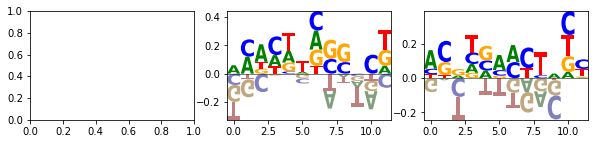

after shift optimz model


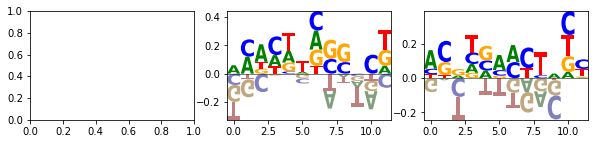


kernel to optimize 1
Epoch:  1, Loss: 0.446
before shift optim.


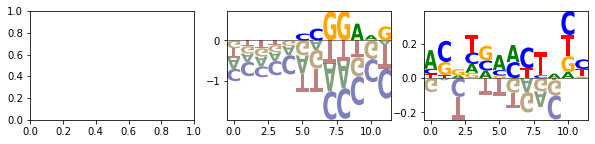

optimize_motif_shift (once)...0.41563129861268305 0.40917415462674633 0.4205287642191134
optimize_motif_shift (again)...0.40917415462674633 0.4160523151167698 0.41729536392095107
after shift optimz model


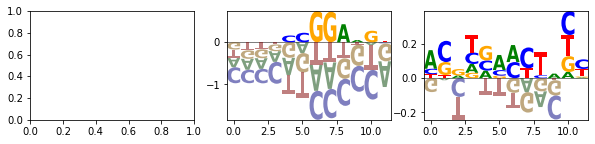


kernel to optimize 2
Epoch:  1, Loss: 0.415
before shift optim.


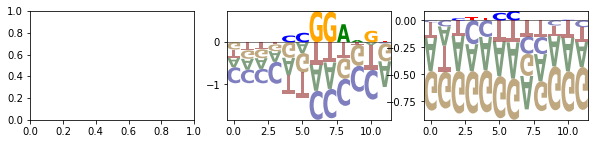

optimize_motif_shift (once)...0.3900191518448053 0.4118940030525048 0.40776746870063607
after shift optimz model


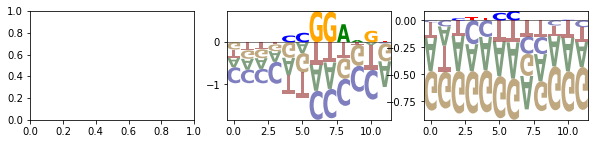

AssertionError: 

In [18]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 2

model_by_k = {}

num_epochs = 500
early_stopping = 15
log_each = 25
res = []
for tf in set(data['tf.name']):
    if 'ZERO' in tf:
        continue
    if tf != 'ETS1':
        continue
    print(tf)
    
    for library, grp in data.groupby('library'):
        # if library != 'TGTGTC20NGA':
            # continue
        data_sel_tf = grp[(grp['tf.name'] == tf)] #  & (grp['cycle'].astype(str) == '1')]
        data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]
        
        if data_sel_tf.shape[0] == 0 or data_sel_zero.shape[0] == 0:
            continue
        print(data_sel_tf.shape[0], data_sel_zero.shape[0])
        print('loading', tf, ':', library)
        reads_tf = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
        reads_zero = mb.bindome.datasets.SELEX.load_read_counts(data=data_sel_zero, library=library)
        
        print(reads_tf.keys(), reads_zero.keys())
        
        for k_r0 in reads_zero:

            k_model = tf + ':' + k_r0
            # print(k_r0, k_tf, k_model)

            n_rounds = len(reads_tf.keys())
            print(n_rounds)
            
            # combine all the positive round data
            df2 = []
            for k in reads_tf.keys():
                df = reads_tf[k]
                df['k'] = k
                df2.append(df)
            df = pd.concat(df2)
            df = df.pivot('seq', 'k', 'counts').fillna(0).reset_index()
            seqlen = list(df['seq'].str.len())[0]
            
            next_data = reads_zero[k_r0].merge(df, on='seq', how='outer').fillna(0) # .astype(int)
            
            new_cols = ['seq', k_r0] + list(df.columns[1:])
            next_data.columns = new_cols
            for i, k in enumerate(next_data.columns[1:]):
                next_data[k] = next_data[k].astype(int)
                next_data[i] = next_data[k].astype(int)
                
            next_data['sum'] = next_data[[i for i in range(0, n_rounds + 1)]].sum(axis=1).values
            next_data = next_data.sort_values('sum', ascending=False)
            
            print('sampling from top n reds in round 1 ...')
            # next_data = next_data.head(100000).reset_index(drop=True)
            print(next_data.shape)
            
            next_data['batch'] = 1
            next_data['is_count_data'] = 1

            print('loading object (# entries)', next_data.shape[0])
            dataset = mb.datasets.SelexDataset(next_data, n_rounds=n_rounds)
            train = tdata.DataLoader(dataset=dataset, batch_size=2500, shuffle=True)
            train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)                

            print('done...')
            ### steps to train model
            
            optimize_motif_shift = True

            n_kernels = 3
            for w in range(12, seqlen, 2):
                # step 1) freeze everything before the current binding mode
                print('next seqlen', w)
                model = mb.models.DinucSelex(use_dinuc=True, kernels=[0] + [w] * (n_kernels - 1),  n_rounds=n_rounds).to(device)
                
                for i in range(0, n_kernels):
                    print('kernel to optimize %i' % i)
                
                    for ki in range(n_kernels):
                        mb.tl.update_grad(model, ki, ki == i)
                                        
                    optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
                    criterion = mb.tl.PoissonLoss()
                    mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=200, early_stopping=20, log_each=200)
                    model.load_state_dict(model.best_model_state) # probably here load the state of the best epoch and save 
                    k_parms = k_model + '_%i' % w
                    model_by_k[k_parms] = copy.deepcopy(model) # store model parameters and fit for later visualization
                    # optimizer for left / right flanks
                    best_loss = model_by_k[k_parms].best_loss
                    
                    print('before shift optim.')
                    mb.pl.conv_mono(model)
                    
                    #######
                    # optimize the flanks through +1/-1 shifts
                    #######
                    if optimize_motif_shift and i != 0:
                        next_loss = None
                        while next_loss is None or next_loss < best_loss:
                            print('optimize_motif_shift (%s)...' % ('once' if next_loss is None else 'again'), end='')
                            model = model_by_k[k_parms]
                            best_loss = model.best_loss

                            model_left = mb.tl.train_shift(copy.deepcopy(model), train, kernel_i=i, shift=1,
                                                           device=device, num_epochs=num_epochs,
                                                           early_stopping=early_stopping, log_each=log_each,
                                                           update_grad_i=i)
                            model_right = mb.tl.train_shift(copy.deepcopy(model), train, kernel_i=i, shift=-1,
                                                            device=device, num_epochs=num_epochs,
                                                            early_stopping=early_stopping, log_each=log_each,
                                                            update_grad_i=i)
                            print(best_loss, model_left.best_loss, model_right.best_loss)
                            best = sorted([[model, best_loss],
                                           [model_left, model_left.best_loss],
                                           [model_right, model_right.best_loss]], key= lambda x: x[-1])
                            next_model, next_loss = best[0]
                            model_by_k[k_parms] = copy.deepcopy(next_model)

                    model = model_by_k[k_parms]
                    n_feat = sum([np.prod(layer.kernel_size) for conv in [model.conv_mono, model.conv_di] for layer in conv if layer is not None])
                    l_best = model.best_loss

                    print('after shift optimz model')
                    mb.pl.conv_mono(model_by_k[k_parms])
                    print('')
                
                assert False

                r = [k_parms, w, n_feat, l_best]
                # print(r)
                res.append(r)
                print('')


            assert False
                
                # stop (debugging)
                

In [19]:
!ls -ltrh /mnt/c/Users/ignacio/Dropbox/annotations/selex/PRJEB3289/ETS1_TGTAAA20NGA*

ls: cannot access '/mnt/c/Users/ignacio/Dropbox/annotations/selex/PRJEB3289/ETS1_TGTAAA20NGA*': No such file or directory


In [20]:
mb.tl.PoissonLoss().forward(torch.zeros(1, 1), torch.zeros(1, 1) + 1)

tensor(inf)

Text(0.5, 6.0, 'binding mode rel activity')

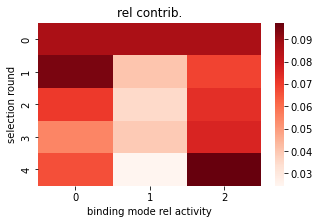

In [21]:
import seaborn as sns
rcParams['figure.figsize'] = 5, 3

activity = np.exp(model.log_activity.weight.cpu().detach().numpy())
rel_activity = activity / np.sum(activity)
sns.heatmap(rel_activity.T, cmap='Reds')
plt.title('rel contrib.')
plt.ylabel('selection round')
plt.xlabel('binding mode rel activity')


Text(0, 0.5, 'loss')

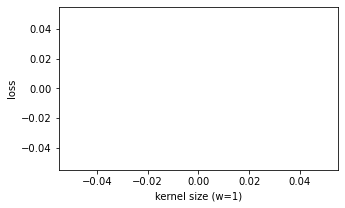

In [22]:
df = pd.DataFrame(res, columns=['k', 'w.1', 'n.parms', 'loss'])
plt.plot(df['w.1'], df['loss'])
plt.xlabel('kernel size (w=1)')
plt.ylabel('loss')

ETS1:ZeroCycle_ES0_TGTAAA20NGA_0_20


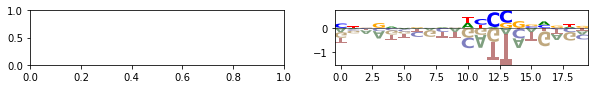

ETS1:ZeroCycle_ES0_TGTAAA20NGA_0_22


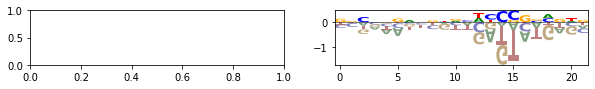

ETS1:ZeroCycle_ES0_TGTAAA20NGA_0_24


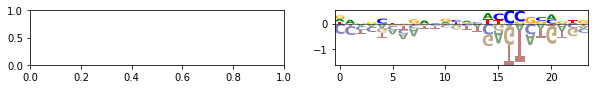

ETS1:ZeroCycle_ES0_TGTAAA20NGA_0_26


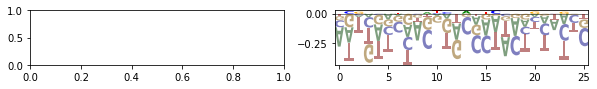

In [42]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 1
for k in list(model_by_k.keys()):
    print(k)
    model = model_by_k[k] 
    mb.pl.conv_mono(model)
    # print('')
    # break

In [50]:
print('loading object (# entries)', next_data.shape[0])
dataset = mb.datasets.SelexDataset(next_data, n_rounds=n_rounds)
train = tdata.DataLoader(dataset=dataset, batch_size=10000, shuffle=True)

print('done...')

### steps to train model
model = mb.models.DinucSelex(use_dinuc=True, kernels=[0, 14, 8],  n_rounds=n_rounds).to(device)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()

# mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=500, early_stopping=100, log_each=10)

loading object (# entries) 50
done...
Dinuc features not implemented yet. Using only mononuc features.


In [70]:
%load_ext line_profiler
%lprun -f mb.tl.train_network mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10, early_stopping=20, log_each=1)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Epoch:  1, Loss: -0.517
Epoch:  2, Loss: -0.970
Epoch:  3, Loss: -1.369
Epoch:  4, Loss: -1.605
Epoch:  5, Loss: -1.805
Epoch:  6, Loss: -2.047
Epoch:  7, Loss: -2.227
Epoch:  8, Loss: -1.982
Epoch:  9, Loss: -1.990
Epoch: 10, Loss: -2.385


Timer unit: 1e-06 s

Total time: 3.32574 s
File: /mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/multibind/multibind/tl/prediction.py
Function: train_network at line 61

Line #      Hits         Time  Per Hit   % Time  Line Contents
    61                                           def train_network(net, train_dataloader, device, optimiser, criterion, num_epochs=15, early_stopping=-1, log_each=None):
    62                                               global loss_history
    63         1          4.0      4.0      0.0      loss_history = []
    64         1          1.0      1.0      0.0      best_loss = None
    65         1          1.0      1.0      0.0      best_epoch = -1
    66        11          9.0      0.8      0.0      for epoch in range(num_epochs):
    67        10         11.0      1.1      0.0          running_loss = 0
    68        40    2916584.0  72914.6     87.7          for i, batch in enumerate(train_dataloader):
    69                                        

### Custom optimization pipeline: one layer is flexible and the others are frozen.

Dinuc features not implemented yet. Using only mononuc features.


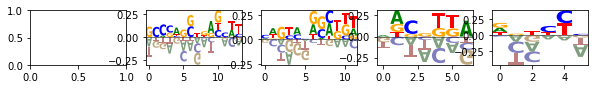

i
Epoch:  1, Loss: -43.166


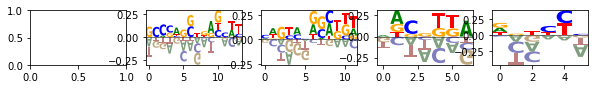

i
Epoch:  1, Loss: -73.194


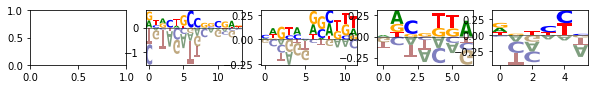

i
Epoch:  1, Loss: -74.375


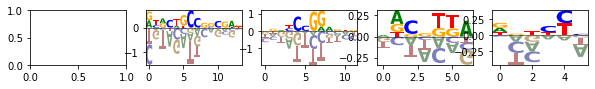

i
Epoch:  1, Loss: -74.538


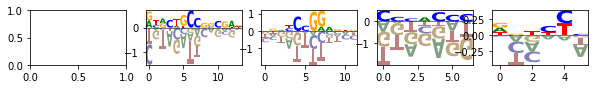

i
Epoch:  1, Loss: -74.554


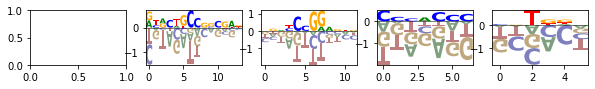

In [70]:
### steps to train model
kernels = [0, 14, 12, 7, 6]
model = mb.models.DinucSelex(use_dinuc=True, kernels=kernels, n_rounds=n_rounds).to(device)
mb.pl.conv_mono(model)

for i in range(0, len(kernels)):
    print('i')
    for ki in range(len(kernels)):
        update_grad(model, ki, ki == i)

    optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
    criterion = mb.tl.PoissonLoss()
    mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=200, early_stopping=20, log_each=200)
    mb.pl.conv_mono(model)

In [52]:
def train_network(net, train_dataloader, device, optimiser, criterion, num_epochs=15, early_stopping=-1, log_each=None):
    global loss_history
    loss_history = []
    best_loss = None
    best_epoch = -1
    for epoch in range(num_epochs):
        running_loss = 0
        for i, batch in enumerate(train_dataloader):
            # Get a batch and potentially send it to GPU memory.
            # print(batch.keys())
            # mononuc = batch["mononuc"].type(torch.LongTensor).to(device)
            mononuc = batch['mononuc'].to(device)
            # mononuc_rev = batch['mononuc_rev'].to(device)
            # dinuc = batch['dinuc'].type(torch.LongTensor).to(device) if 'dinuc' in batch else None
            # dinuc_rev = batch['dinuc_rev'].to(device) if 'dinuc_rev' in batch else None
            b = batch['batch'].to(device) if 'batch' in batch else None
            target = batch['target'].to(device) if 'target' in batch else None
            rounds = batch['rounds'].to(device) if 'rounds' in batch else None
            is_count_data = batch['is_count_data'] if 'is_count_data' in batch else None
            seqlen = batch['seqlen'] if 'seqlen' in batch else None
            countsum = batch['countsum'].to(device) if 'countsum' in batch else None

            inputs = (mononuc, b, seqlen, countsum)
            optimiser.zero_grad()  # PyTorch calculates gradients by accumulating contributions to them (useful for
            # RNNs).  Hence we must manully set them to zero before calculating them.
            outputs = net(inputs)  # Forward pass through the network.
            loss = criterion(outputs, rounds)
            # loss = criterion(outputs/(1+outputs), target) #, is_count_data)
            # print('here...')
            # print(loss)
            # assert False
            loss.backward()  # Calculate gradients.
            optimiser.step()  # Step to minimise the loss according to the gradient.
            running_loss += loss.item()

        loss_final = running_loss / len(train_dataloader)
        if log_each is None or (epoch % log_each == 0):
            print("Epoch: %2d, Loss: %.3f" % (epoch + 1, loss_final))

        if best_loss is None or loss_final < best_loss:
            best_loss = loss_final
            best_epoch = epoch
            net.best_model_state = copy.deepcopy(net.state_dict())

        # print("Epoch: %2d, Loss: %.3f" % (epoch + 1, running_loss / len(train_dataloader)))
        loss_history.append(loss_final)

        if early_stopping > 0 and epoch >= best_epoch + early_stopping:
            break

In [108]:
# for param in model.parameters():
#     print(param, param.requires_grad)

In [104]:
# mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10, early_stopping=5, log_each=11)

ALX4:ZeroCycle_ES0_TGTGTC20NGA_0:ALX4_TGTGTC20NGA_W_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


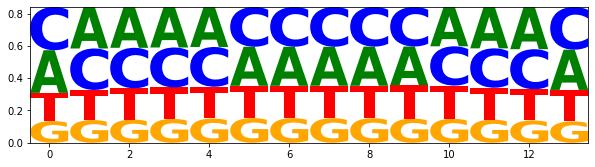

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


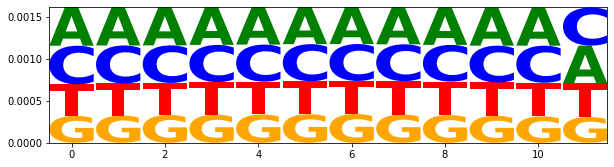

In [129]:
for k in model_by_k:
    print(k)
    model = model_by_k[k] 
    mb.pl.conv_mono(model)
    print('')

In [45]:
for k in model_by_k:
    print(k)

ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_1
ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_1
ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_3
ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_3
ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_4
ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_4
ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_2
ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_2
ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_2
ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_2
ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_4
ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_4
ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_3
ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_3
ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_6
ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_6
ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_1
ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_1
ETS1:Zer

ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


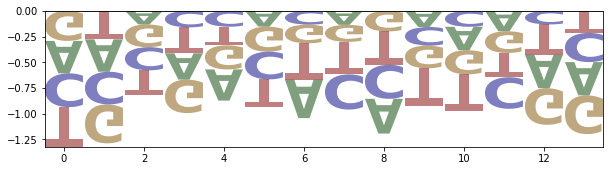

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


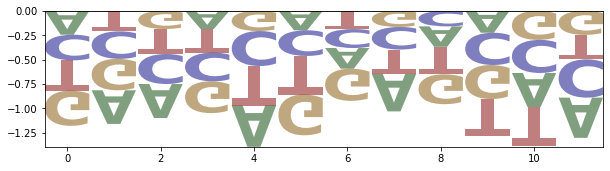


ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


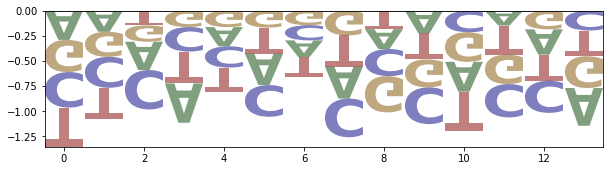

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


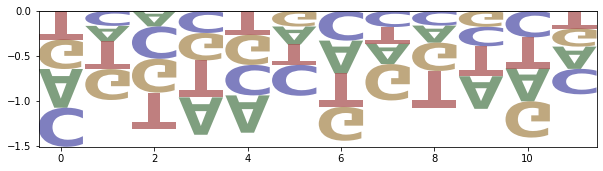


ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


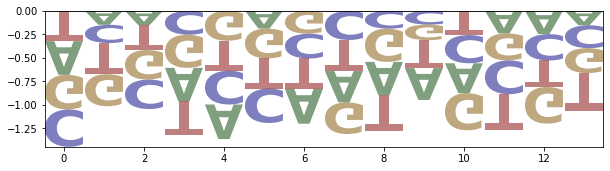

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


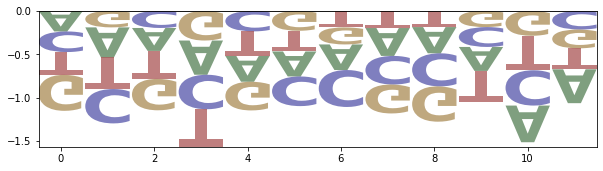


ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


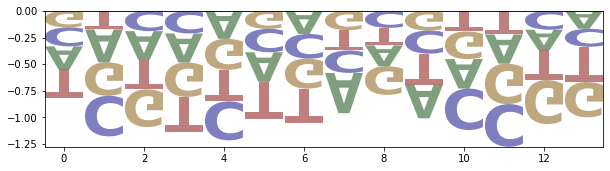

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


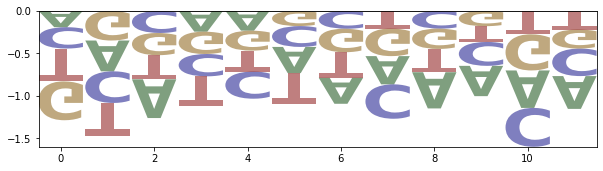


FOXA1:ZeroCycle_TAGCGT40NTCA_0_0:FOXA1_FL_1_KX_TAGCGT40NTCA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


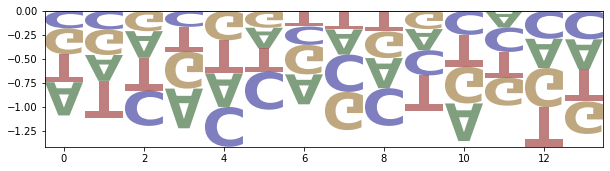

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


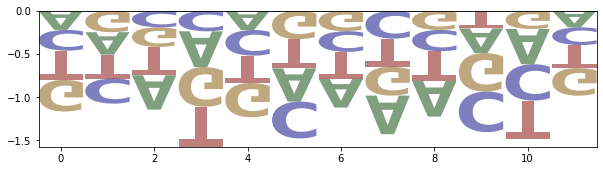


FOXA1:ZeroCycle_TCCCAA40NGAA_0_0:FOXA1_eDBD_1_KN_TCCCAA40NGAA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


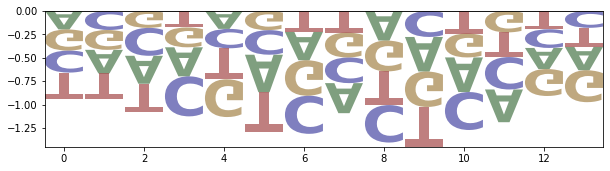

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


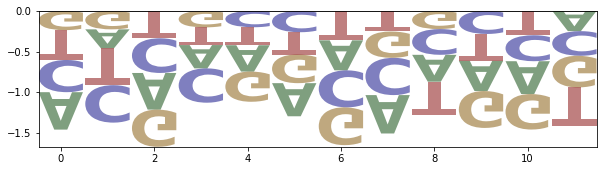


FOXA1:ZeroCycle_TCCCAT40NTGT_0_0:FOXA1_FL_1_KX_TCCCAT40NTGT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


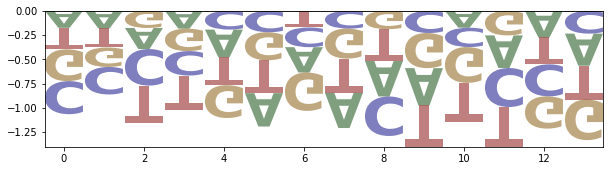

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


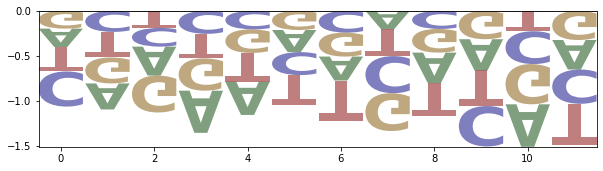


FOXA1:ZeroCycle_TTCTAA40NAAT_0_0:FOXA1_eDBD_1_KN_TTCTAA40NAAT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


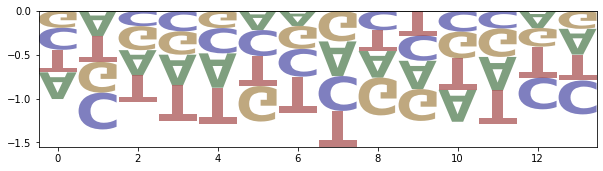

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


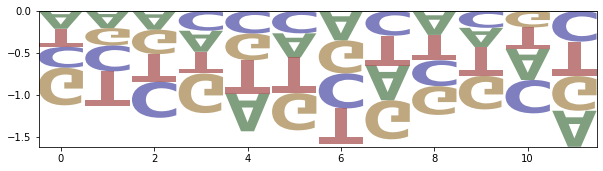


ALX4:ZeroCycle_TCTATT40NCAT_0_0:ALX4_eDBD_1_KW_TCTATT40NCAT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


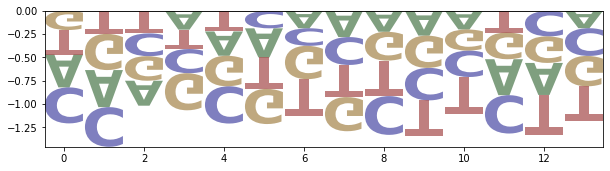

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


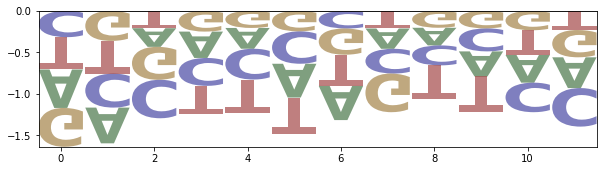


ALX4:ZeroCycle_TGCGTA40NTCA_0_0:ALX4_eDBD_1_KW_TGCGTA40NTCA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


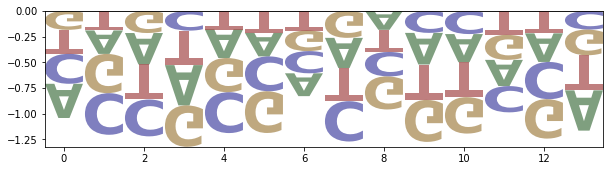

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


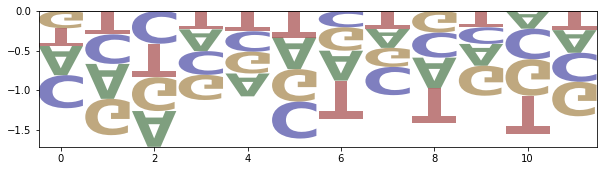


ALX4:ZeroCycle_TGTGTC20NGA_0_0:ALX4_TGTGTC20NGA_W_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


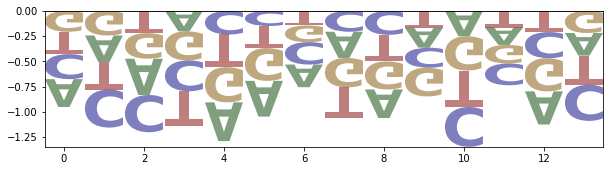

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


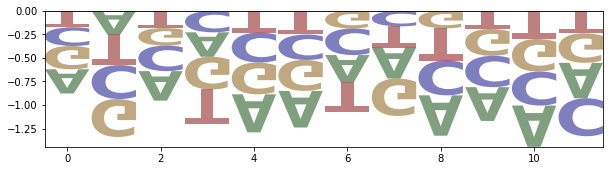


ALX4:ZeroCycle_ES0_TGTGTC20NGA_0:ALX4_TGTGTC20NGA_W_1
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


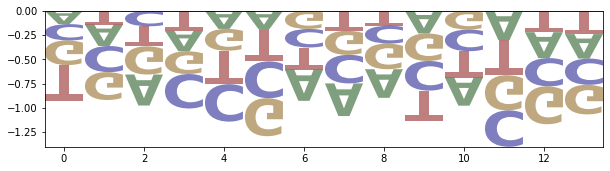

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


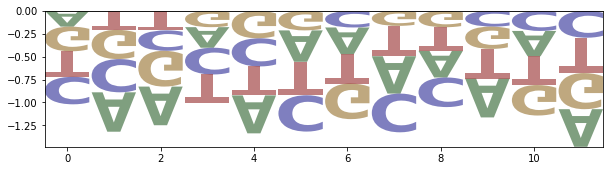


ALX1:ZeroCycle_TACCAA40NTTA_0_0:ALX1_FL_1_KX_TACCAA40NTTA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


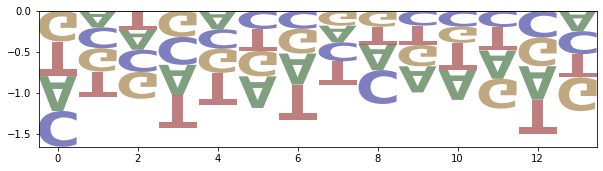

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


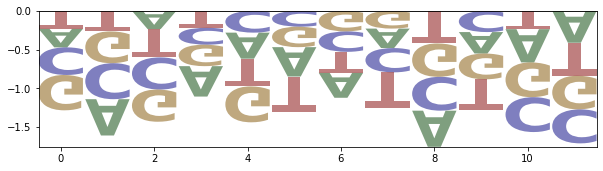


ALX1:ZeroCycle_TCCTTG40NGGT_0_0:ALX1_FL_1_KX_TCCTTG40NGGT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


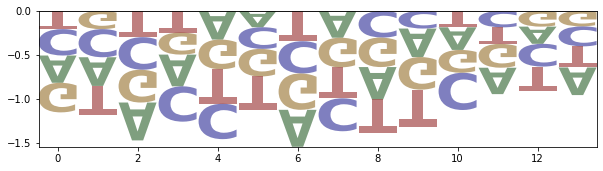

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


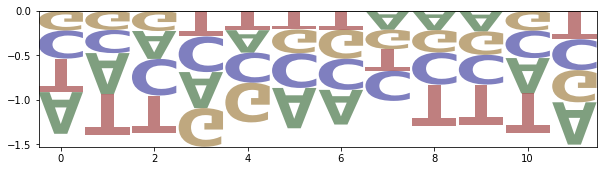


EGR1:ZeroCycle_TAGACA40NGTC_0_0:EGR1_eDBD_1_KAN_TAGACA40NGTC
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


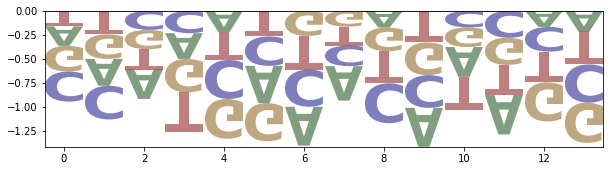

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


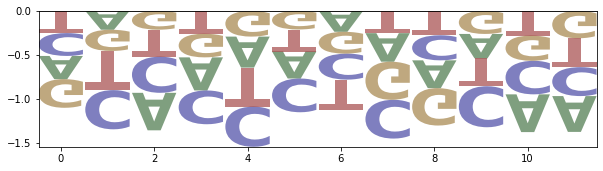


EGR1:ZeroCycle_TCAGCC40NTTC_0_0:EGR1_eDBD_1_KR_TCAGCC40NTTC
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


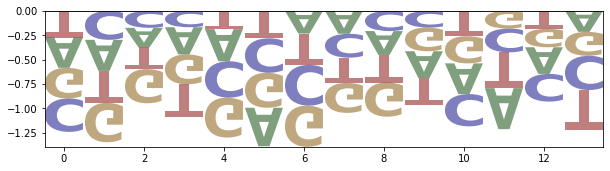

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


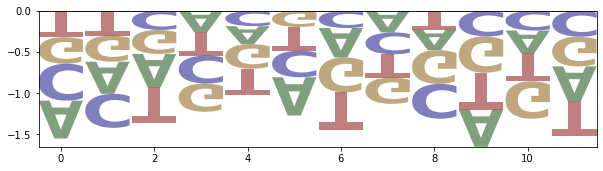


EGR1:ZeroCycle_TCCGCT40NGCG_0_0:EGR1_eDBD_1_KAN_TCCGCT40NGCG
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


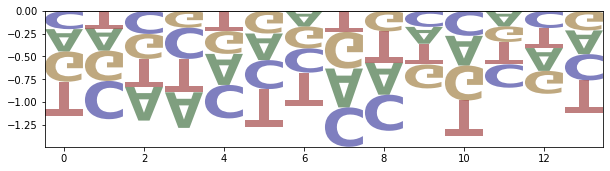

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


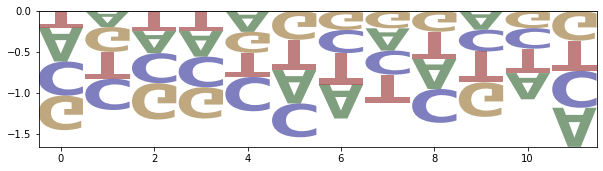


EGR1:ZeroCycle_TTGTAC40NGTA_0_0:EGR1_eDBD_1_KR_TTGTAC40NGTA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


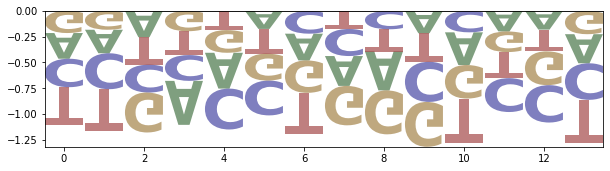

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


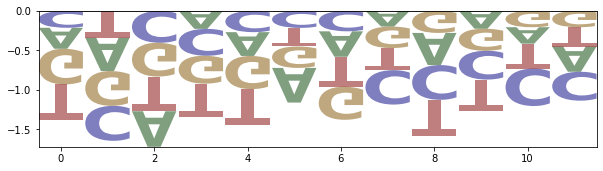

In [47]:
model_selection = ['ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_1', 'ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_1', 'ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_1', 'ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_1', 'FOXA1:ZeroCycle_TAGCGT40NTCA_0_0:FOXA1_FL_1_KX_TAGCGT40NTCA', 'FOXA1:ZeroCycle_TCCCAA40NGAA_0_0:FOXA1_eDBD_1_KN_TCCCAA40NGAA', 'FOXA1:ZeroCycle_TCCCAT40NTGT_0_0:FOXA1_FL_1_KX_TCCCAT40NTGT', 'FOXA1:ZeroCycle_TTCTAA40NAAT_0_0:FOXA1_eDBD_1_KN_TTCTAA40NAAT', 'ALX4:ZeroCycle_TCTATT40NCAT_0_0:ALX4_eDBD_1_KW_TCTATT40NCAT', 'ALX4:ZeroCycle_TGCGTA40NTCA_0_0:ALX4_eDBD_1_KW_TGCGTA40NTCA', 'ALX4:ZeroCycle_TGTGTC20NGA_0_0:ALX4_TGTGTC20NGA_W_1', 'ALX4:ZeroCycle_ES0_TGTGTC20NGA_0:ALX4_TGTGTC20NGA_W_1', 'ALX1:ZeroCycle_TACCAA40NTTA_0_0:ALX1_FL_1_KX_TACCAA40NTTA', 'ALX1:ZeroCycle_TCCTTG40NGGT_0_0:ALX1_FL_1_KX_TCCTTG40NGGT', 'EGR1:ZeroCycle_TAGACA40NGTC_0_0:EGR1_eDBD_1_KAN_TAGACA40NGTC', 'EGR1:ZeroCycle_TCAGCC40NTTC_0_0:EGR1_eDBD_1_KR_TCAGCC40NTTC', 'EGR1:ZeroCycle_TCCGCT40NGCG_0_0:EGR1_eDBD_1_KAN_TCCGCT40NGCG', 'EGR1:ZeroCycle_TTGTAC40NGTA_0_0:EGR1_eDBD_1_KR_TTGTAC40NGTA']
for k in model_selection:
    print(k)
    model = model_by_k[k] 
    mb.pl.conv_mono(model)
    print('')

In [50]:
data[(data['tf.name'] == 'ETS1') & (data['library'] == 'TGTAAA20NGA')]

filename      library batch cycle tf.name  accession
8   ETS1_TGTAAA20NGA_AF_1.fastq.gz  TGTAAA20NGA    AF     1    ETS1  PRJEB3289
13  ETS1_TGTAAA20NGA_AF_3.fastq.gz  TGTAAA20NGA    AF     3    ETS1  PRJEB3289
16  ETS1_TGTAAA20NGA_AF_4.fastq.gz  TGTAAA20NGA    AF     4    ETS1  PRJEB3289
22  ETS1_TGTAAA20NGA_AF_2.fastq.gz  TGTAAA20NGA    AF     2    ETS1  PRJEB3289

ETS1, using the full r0 and r1 data of one library:

In [83]:
# model_by_k = {}
tf = 'ETS1'
library = 'TGTAAA20NGA'
grp = data[data['library'] == 'TGTAAA20NGA']

data_sel_tf = grp[grp['tf.name'] == tf]
data_sel_tf = data_sel_tf[data_sel_tf['cycle'] == '1']

print('loading', tf, ':', library)
reads_tf = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]
data_sel_zero = data_sel_zero[data_sel_zero['filename'] != 'ZeroCycle_TGTAAA20NGA_0_0.fastq.gz']
reads_zero = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_zero, library=library)

print(reads_tf.keys())
print(reads_zero.keys())

for k_tf in reads_tf:
    for k_r0 in reads_zero:
        print(k_r0, k_tf)

        k_model = tf + ':' + k_r0 + ':' + k_tf

        n_rounds = 1

        next_data = reads_zero[k_r0].merge(reads_tf[k_tf], on='seq', how='outer').fillna(0) # .astype(int)
        new_cols = ['seq', k_r0, k_tf]
        next_data.columns = ['seq', k_r0, k_tf]
        for i, k in enumerate([k_r0, k_tf]):
            next_data[k] = next_data[k].astype(int)
            next_data[i] = next_data[k].astype(int)


        # next_data = next_data.sample(n=10000)
        print(next_data.shape)

        print(next_data.head())

        # not needed for the current model, because the enrichment is not predicted
        # next_data = mb.tl.calculate_enrichment(next_data, cols=next_data.columns[1:])

        # assign batch and data type
        next_data['batch'] = 1
        next_data['is_count_data'] = 1

        dataset = mb.datasets.SelexDataset(next_data) # n_rounds=n_rounds)
        train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
        # train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)                

        ### steps to train model
        model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12]).to(device) #, n_rounds=n_rounds)
        optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        criterion = mb.tl.PoissonLoss()
        mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10, early_stopping=-1, log_each=1)

        # probably here load the state of the best epoch and save 
        model.load_state_dict(model.best_model_state)

        # store model parameters and fit for later visualization
        # model_by_k[k_model] = model

        # assert False

        # stop (debugging)


loading ETS1 : TGTAAA20NGA
# uniq reads/total counts 178944/180855
# uniq reads/total counts 228351/228457
dict_keys(['ETS1_TGTAAA20NGA_AF_1'])
dict_keys(['ZeroCycle_ES0_TGTAAA20NGA_0'])
ZeroCycle_ES0_TGTAAA20NGA_0 ETS1_TGTAAA20NGA_AF_1
(407295, 5)
                    seq  ZeroCycle_ES0_TGTAAA20NGA_0  ETS1_TGTAAA20NGA_AF_1  \
0  GGACCTTACCGTTATACGCC                            2                      0   
1  TCATATCCCAACTCACGAGC                            2                      0   
2  TCATGCATACCTTAATGGTC                            2                      0   
3  ACCTGCTGACCGTATAGGAG                            2                      0   
4  TATACTTCCAACTCACGGCC                            2                      0   

   0  1  
0  2  0  
1  2  0  
2  2  0  
3  2  0  
4  2  0  
Epoch:  1, Loss: 0.862
Epoch:  2, Loss: 0.842
Epoch:  3, Loss: 0.842
Epoch:  4, Loss: 0.842
Epoch:  5, Loss: 0.841
Epoch:  6, Loss: 0.841
Epoch:  7, Loss: 0.841
Epoch:  8, Loss: 0.841
Epoch:  9, Loss: 0.841
Epoch: 10

0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


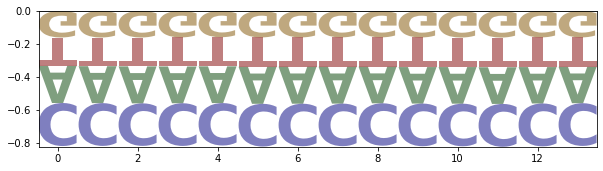

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


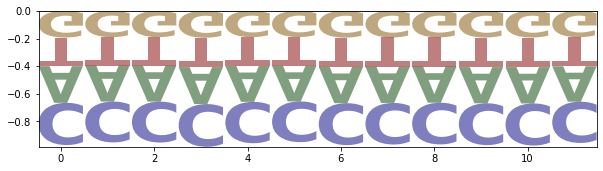

In [117]:
mb.pl.conv_mono(model)

seq  ZeroCycle_TGTAAA20NGA_0_0  ETS1_TGTAAA20NGA_AF_1   0  \
0  TCGTATGCCGTCTTCTGCTT                         10                    135  10   

     1  batch  is_count_data  
0  135      1              1

In [85]:
all_targets, all_outputs = [], []
for i, batch in enumerate(train_test):
    # Get a batch and potentially send it to GPU memory.
    # print(batch.keys())
    # mononuc = batch["mononuc"].type(torch.LongTensor).to(device)
    mononuc = batch['mononuc'].to(device)
    mononuc_rev = batch['mononuc_rev'].to(device)
    dinuc = batch['dinuc'].type(torch.LongTensor).to(device) if 'dinuc' in batch else None
    dinuc_rev = batch['dinuc_rev'].to(device) if 'dinuc_rev' in batch else None
    b = batch['batch'].to(device) if 'batch' in batch else None
    target = batch['target'].to(device) if 'target' in batch else None
    rounds = batch['rounds'].to(device) if 'rounds' in batch else None
    is_count_data = batch['is_count_data'] if 'is_count_data' in batch else None
    seqlen = batch['seqlen'] if 'seqlen' in batch else None

    inputs = (mononuc, mononuc_rev, dinuc, dinuc_rev, b, seqlen, torch.sum(rounds, axis=1))
    outputs = model(inputs)  # Forward pass through the network.
    all_targets.append(rounds.squeeze().cpu().detach().numpy())
    all_outputs.append(outputs.squeeze().cpu().detach().numpy())
    if i >= 200:
        break

In [86]:
all_outputs

[array([1.1288553 , 0.87114465], dtype=float32),
 array([1.165779  , 0.83422107], dtype=float32),
 array([1.0370189 , 0.96298105], dtype=float32),
 array([1.1396528, 0.8603472], dtype=float32),
 array([1.1407241 , 0.85927594], dtype=float32),
 array([1.1888554, 0.8111447], dtype=float32),
 array([1.2012691, 0.7987308], dtype=float32),
 array([1.220229, 0.779771], dtype=float32),
 array([1.0233854 , 0.97661453], dtype=float32),
 array([1.2147138 , 0.78528625], dtype=float32),
 array([1.2240547 , 0.77594537], dtype=float32),
 array([1.2179208 , 0.78207916], dtype=float32),
 array([1.0691836 , 0.93081635], dtype=float32),
 array([1.1262522, 0.8737478], dtype=float32),
 array([1.1984241, 0.8015758], dtype=float32),
 array([1.0537881, 0.946212 ], dtype=float32),
 array([1.1950281, 0.8049718], dtype=float32),
 array([1.0765917, 0.9234082], dtype=float32),
 array([1.0871614 , 0.91283846], dtype=float32),
 array([1.2492644, 0.7507356], dtype=float32),
 array([0.9659248, 1.0340751], dtype=float

ETS1, using only a subset of the r0 and r1 data (very many epochs)

In [93]:
# model_by_k = {}
tf = 'ETS1'
library = 'TGTAAA20NGA'
grp = data[data['library'] == 'TGTAAA20NGA']

data_sel_tf = grp[grp['tf.name'] == tf]
data_sel_tf = data_sel_tf[data_sel_tf['cycle'] == '1']

print('loading', tf, ':', library)
reads_tf = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]
data_sel_zero = data_sel_zero[data_sel_zero['filename'] != 'ZeroCycle_TGTAAA20NGA_0_0.fastq.gz']
reads_zero = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_zero, library=library)

print(reads_tf.keys())
print(reads_zero.keys())

for k_tf in reads_tf:
    for k_r0 in reads_zero:
        print(k_r0, k_tf)

        k_model = tf + ':' + k_r0 + ':' + k_tf

        n_rounds = 1

        next_data = reads_zero[k_r0].merge(reads_tf[k_tf], on='seq', how='outer').fillna(0) # .astype(int)
        new_cols = ['seq', k_r0, k_tf]
        next_data.columns = ['seq', k_r0, k_tf]
        for i, k in enumerate([k_r0, k_tf]):
            next_data[k] = next_data[k].astype(int)
            next_data[i] = next_data[k].astype(int)


        next_data = next_data.sample(n=1000)
        print(next_data.shape)

        print(next_data.head())

        # not needed for the current model, because the enrichment is not predicted
        # next_data = mb.tl.calculate_enrichment(next_data, cols=next_data.columns[1:])

        # assign batch and data type
        next_data['batch'] = 1
        next_data['is_count_data'] = 1

        dataset = mb.datasets.SelexDataset(next_data) # n_rounds=n_rounds)
        train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
        # train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)                

        ### steps to train model
        model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12]).to(device) #, n_rounds=n_rounds)
        optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        criterion = mb.tl.PoissonLoss()
        mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10000, early_stopping=-1, log_each=100)

        # probably here load the state of the best epoch and save 
        model.load_state_dict(model.best_model_state)

        # store model parameters and fit for later visualization
        # model_by_k[k_model] = model

        # assert False

        # stop (debugging)


loading ETS1 : TGTAAA20NGA
# uniq reads/total counts 178944/180855
# uniq reads/total counts 228351/228457
dict_keys(['ETS1_TGTAAA20NGA_AF_1'])
dict_keys(['ZeroCycle_ES0_TGTAAA20NGA_0'])
ZeroCycle_ES0_TGTAAA20NGA_0 ETS1_TGTAAA20NGA_AF_1
(1000, 5)
                         seq  ZeroCycle_ES0_TGTAAA20NGA_0  \
356705  ACACACTAACGCCACATTGC                            0   
346616  GTTCCACGCATCCTCCCAAC                            0   
329747  CCGCATGAACAACCACGTTG                            0   
55764   CACACCAGCTATACCCTATT                            1   
228237  CTGAGTGAACCACGGTGACT                            1   

        ETS1_TGTAAA20NGA_AF_1  0  1  
356705                      1  0  1  
346616                      1  0  1  
329747                      1  0  1  
55764                       0  1  0  
228237                      0  1  0  
Epoch:  1, Loss: 1.249
Epoch: 101, Loss: 0.844
Epoch: 201, Loss: 0.843
Epoch: 301, Loss: 0.842
Epoch: 401, Loss: 0.840
Epoch: 501, Loss: 0.838
Epoch: 601, Los

0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


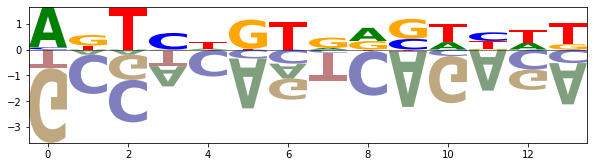

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


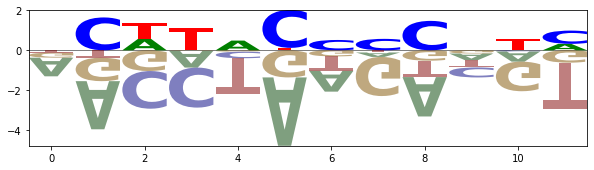

In [94]:
mb.pl.conv_mono(model)

In [95]:
print(model.log_activity.weight)

Parameter containing:
tensor([[ 2.7356e-05, -8.3618e-02],
        [-6.7003e-06, -2.9363e-01],
        [ 1.6522e-05, -5.8203e-01]], requires_grad=True)


In [96]:
print(model.log_eta.weight)

Parameter containing:
tensor([[ 0.4173],
        [-0.4173]], requires_grad=True)


ETS1, fitting to all rounds of one library (full dataset)

In [9]:
# model_by_k = {}
tf = 'ETS1'
library = 'TGTAAA20NGA'
grp = data[data['library'] == 'TGTAAA20NGA']

data_sel_tf = grp[grp['tf.name'] == tf]
# data_sel_tf = data_sel_tf[data_sel_tf['cycle'] == '1']

print('loading', tf, ':', library)
reads_tf = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]
data_sel_zero = data_sel_zero[data_sel_zero['filename'] != 'ZeroCycle_TGTAAA20NGA_0_0.fastq.gz']
reads_zero = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_zero, library=library)

print(reads_tf.keys())
print(reads_zero.keys())

# model over all 4 rounds

k_r0 = list(reads_zero.keys())[0]
next_data = reads_zero[k_r0]
for k_tf in reads_tf:
    next_data = next_data.merge(reads_tf[k_tf], on='seq', how='outer').fillna(0) # .astype(int)

n_rounds = 4
next_data.columns = ['seq', 0, 1, 2, 3, 4]
for i, k in enumerate([0, 1, 2, 3, 4]):
    next_data[k] = next_data[k].astype(int)

# next_data = next_data.sample(n=1000)
print(next_data.shape)

print(next_data.head())

# not needed for the current model, because the enrichment is not predicted
# next_data = mb.tl.calculate_enrichment(next_data, cols=next_data.columns[1:])

# assign batch and data type
# next_data['batch'] = 1
# next_data['is_count_data'] = 1

dataset = mb.datasets.SelexDataset(next_data, n_rounds=n_rounds)
train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)                

### steps to train model
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12], n_rounds=n_rounds).to(device)
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = mb.tl.PoissonLoss()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10, early_stopping=-1, log_each=1)

# probably here load the state of the best epoch and save 
model.load_state_dict(model.best_model_state)

# store model parameters and fit for later visualization
# model_by_k[k_model] = model

# assert False

# stop (debugging)


loading ETS1 : TGTAAA20NGA
# uniq reads/total counts 178944/180855
# uniq reads/total counts 172559/230033
# uniq reads/total counts 42327/94179
# uniq reads/total counts 174479/179246
# uniq reads/total counts 228351/228457
dict_keys(['ETS1_TGTAAA20NGA_AF_1', 'ETS1_TGTAAA20NGA_AF_3', 'ETS1_TGTAAA20NGA_AF_4', 'ETS1_TGTAAA20NGA_AF_2'])
dict_keys(['ZeroCycle_ES0_TGTAAA20NGA_0'])
(772868, 6)
                    seq  0  1  2  3  4
0  TCCGTGGCTGCCCACGTGCC  2  0  0  0  0
1  TCATGCATACCTTAATGGTC  2  0  0  0  0
2  TAATGCCTCGCCACGCGCGG  2  0  0  0  0
3  AATAAGGACGACTGCAGCGC  2  0  0  0  0
4  CGTGTAAAGGCACGTCCCGA  2  0  0  0  0
Epoch:  1, Loss: 0.472
Epoch:  2, Loss: 0.445
Epoch:  3, Loss: 0.444
Epoch:  4, Loss: 0.442
Epoch:  5, Loss: 0.441
Epoch:  6, Loss: 0.441
Epoch:  7, Loss: 0.440
Epoch:  8, Loss: 0.439
Epoch:  9, Loss: 0.438
Epoch: 10, Loss: 0.438


<All keys matched successfully>

0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


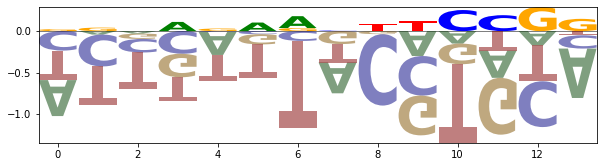

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


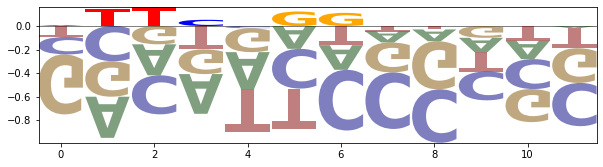

In [10]:
mb.pl.conv_mono(model)

In [11]:
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10, early_stopping=-1, log_each=1)
model.load_state_dict(model.best_model_state)

Epoch:  1, Loss: 0.438
Epoch:  2, Loss: 0.437
Epoch:  3, Loss: 0.437
Epoch:  4, Loss: 0.437
Epoch:  5, Loss: 0.437
Epoch:  6, Loss: 0.437
Epoch:  7, Loss: 0.437
Epoch:  8, Loss: 0.436
Epoch:  9, Loss: 0.436
Epoch: 10, Loss: 0.436


<All keys matched successfully>

0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


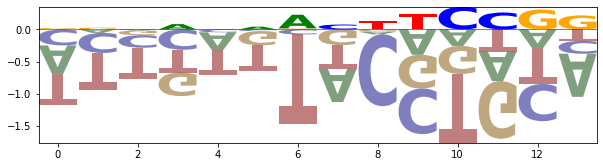

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


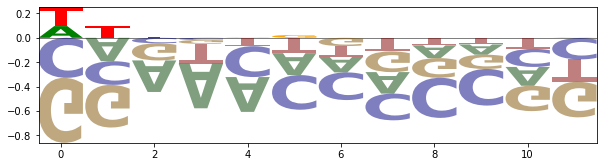

In [12]:
mb.pl.conv_mono(model)

All TF's, using subsets of round 0 and 2

In [14]:
model2_by_k = {}
for tf in set(data['tf.name']):
    if 'ZERO' in tf:
        continue
    print(tf)
    
    for library, grp in data.groupby('library'):
        data_sel_tf = grp[(grp['tf.name'] == tf) & (grp['cycle'] == '2')]
        if data_sel_tf.shape[0] == 0:
            continue

        print('loading', tf, ':', library)
        reads_tf2 = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
        data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]
        reads_zero2 = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_zero, library=library)
        
        print(reads_tf2.keys())
        print(reads_zero2.keys())
        
        for k_tf in reads_tf2:
            for k_r0 in reads_zero2:
                print(k_r0, k_tf)
                
                k_model = tf + ':' + k_r0 + ':' + k_tf

                n_rounds = 1

                next_data2 = reads_zero2[k_r0].merge(reads_tf2[k_tf], on='seq', how='outer').fillna(0) # .astype(int)
                new_cols2 = ['seq', k_r0, k_tf]
                next_data2.columns = ['seq', k_r0, k_tf]
                for i, k in enumerate([k_r0, k_tf]):
                    next_data2[k] = next_data2[k].astype(int)
                    next_data2[i] = next_data2[k].astype(int)


                # next_data = next_data.head(10000)
                next_data2 = next_data2.sample(n=10000)
                print(next_data2.shape)
                
                print(next_data2.head())
                
                # not needed for the current model, because the enrichment is not predicted
                # next_data = mb.tl.calculate_enrichment(next_data, cols=next_data.columns[1:])
                
                # assign batch and data type
                #next_data2['batch'] = 1
                #next_data2['is_count_data'] = 1

                dataset2 = mb.datasets.SelexDataset(next_data2) # n_rounds=n_rounds)
                train2 = tdata.DataLoader(dataset=dataset2, batch_size=256, shuffle=True)
                train_test2 = tdata.DataLoader(dataset=dataset2, batch_size=1, shuffle=False)                
                
                ### steps to train model
                model2 = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12]).to(device) #, n_rounds=n_rounds)
                optimiser2 = topti.Adam(model2.parameters(), lr=0.001, weight_decay=0.0001)
                criterion = mb.tl.PoissonLoss()
                mb.tl.train_network(model2, train2, device, optimiser2, criterion, num_epochs=200, early_stopping=5, log_each=11)
                
                # probably here load the state of the best epoch and save 
                model2.load_state_dict(model2.best_model_state)
                
                # store model parameters and fit for later visualization
                model2_by_k[k_model] = model2
                
                # assert False
                
                # stop (debugging)
                

FOXA1
loading FOXA1 : TAGCGT40NTCA
# uniq reads/total counts 160291/165113
# uniq reads/total counts 147714/148050
dict_keys(['FOXA1_FL_2_KX_TAGCGT40NTCA'])
dict_keys(['ZeroCycle_TAGCGT40NTCA_0_0'])
ZeroCycle_TAGCGT40NTCA_0_0 FOXA1_FL_2_KX_TAGCGT40NTCA
(10000, 5)
                                             seq  ZeroCycle_TAGCGT40NTCA_0_0  \
286507  GAACTTCGCACGCCCCGTTACCCGCACTTATGAATCCATG                           0   
302244  CAATGAACTCCCACCGACACCGTTAACCCAAATGCCCATT                           0   
302536  GCCCTCGCGTCAACAGTACGAGCTACGCCAACTCCCCGCA                           0   
120078  ATTGTGCTCCGGCCCTTCTTCCTCCTTACTGCTACACTAT                           1   
98930   CACCGCTAAGTCTGCCCTCCCATTCCTAGACTAGCCGGAT                           1   

        FOXA1_FL_2_KX_TAGCGT40NTCA  0  1  
286507                           1  0  1  
302244                           1  0  1  
302536                           1  0  1  
120078                           0  1  0  
98930                            0  1  0

FOXA1:ZeroCycle_TAGCGT40NTCA_0_0:FOXA1_FL_2_KX_TAGCGT40NTCA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


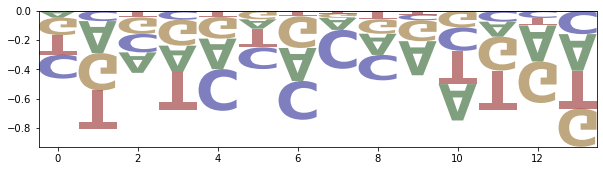

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


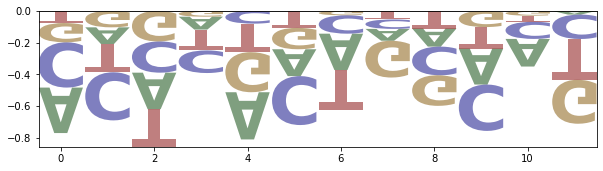


FOXA1:ZeroCycle_TCCCAA40NGAA_0_0:FOXA1_eDBD_2_KN_TCCCAA40NGAA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


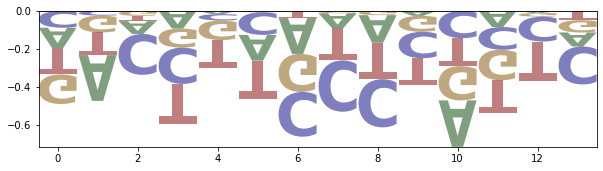

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


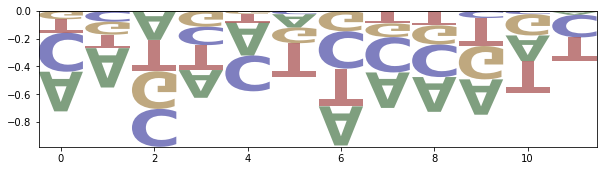


FOXA1:ZeroCycle_TCCCAT40NTGT_0_0:FOXA1_FL_2_KX_TCCCAT40NTGT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


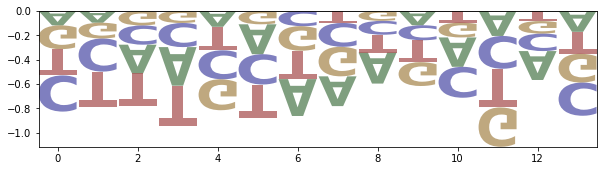

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


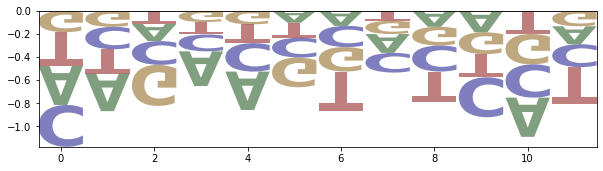


FOXA1:ZeroCycle_TTCTAA40NAAT_0_0:FOXA1_eDBD_2_KN_TTCTAA40NAAT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


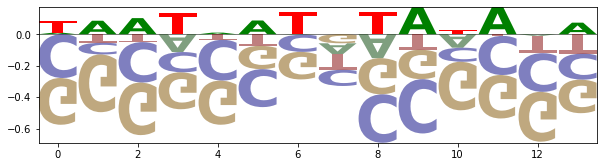

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


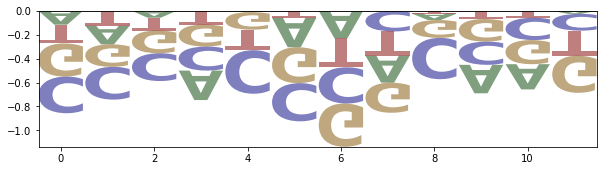


ALX4:ZeroCycle_TCTATT40NCAT_0_0:ALX4_eDBD_2_KW_TCTATT40NCAT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


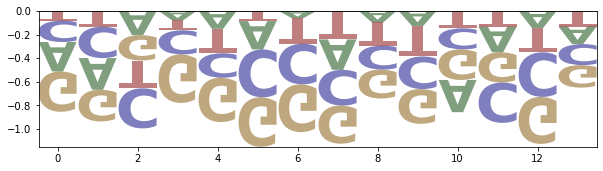

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


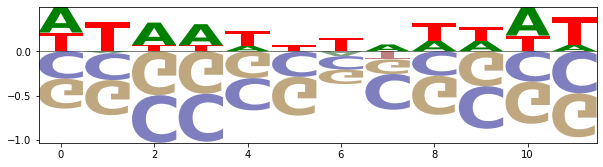


ALX4:ZeroCycle_TGCGTA40NTCA_0_0:ALX4_eDBD_2_KW_TGCGTA40NTCA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


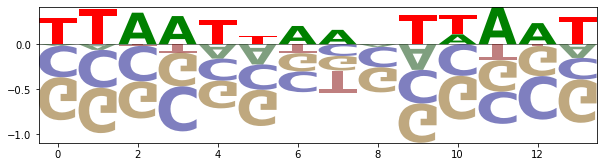

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


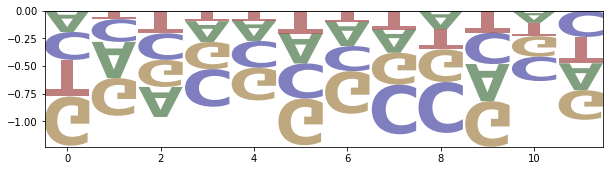


ALX4:ZeroCycle_TGTGTC20NGA_0_0:ALX4_TGTGTC20NGA_W_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


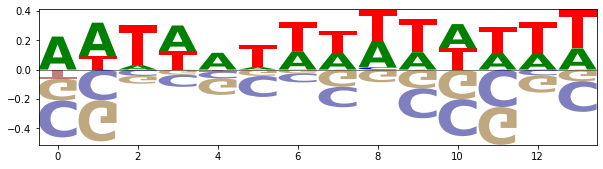

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


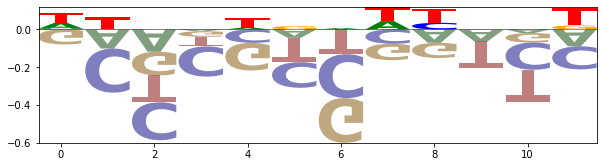


ALX4:ZeroCycle_ES0_TGTGTC20NGA_0:ALX4_TGTGTC20NGA_W_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


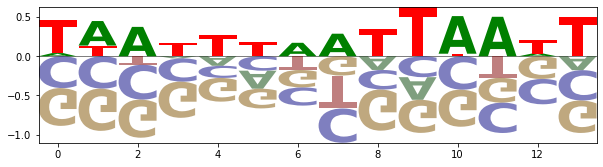

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


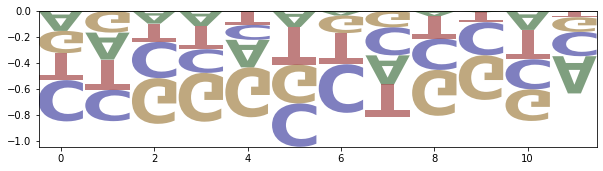


ALX1:ZeroCycle_TACCAA40NTTA_0_0:ALX1_FL_2_KX_TACCAA40NTTA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


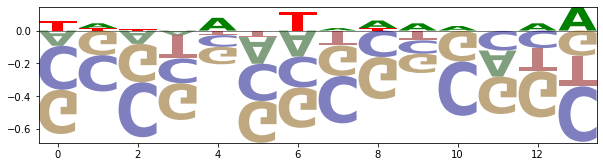

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


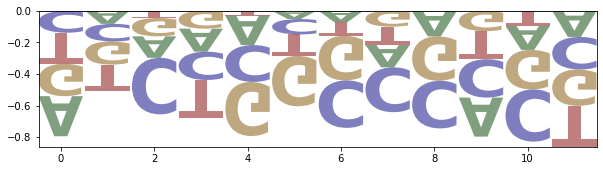


ALX1:ZeroCycle_TCCTTG40NGGT_0_0:ALX1_FL_2_KX_TCCTTG40NGGT
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


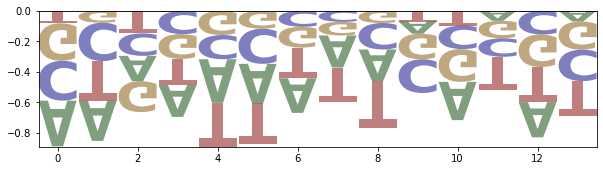

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


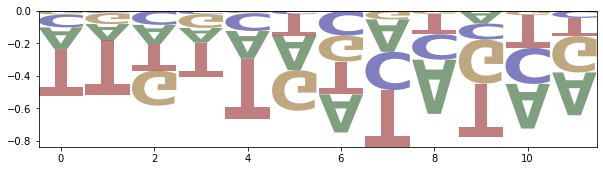


EGR1:ZeroCycle_TACTAT20NATC_0_0:EGR1_TACTAT20NATC_AA_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


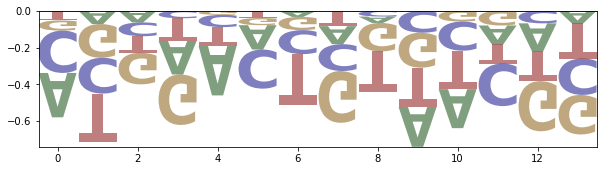

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


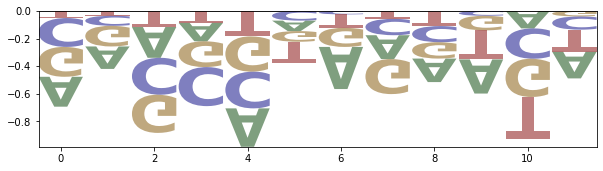


EGR1:ZeroCycle_ES0_TACTAT20NATC_0:EGR1_TACTAT20NATC_AA_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


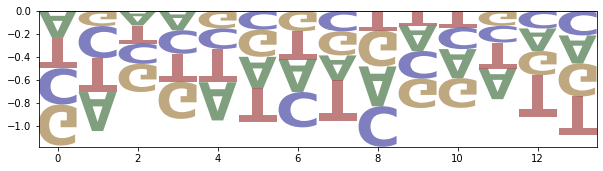

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


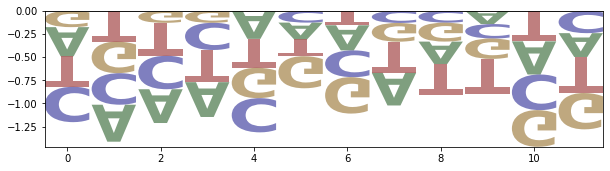


EGR1:ZeroCycle_TAGACA40NGTC_0_0:EGR1_eDBD_2_KAN_TAGACA40NGTC
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


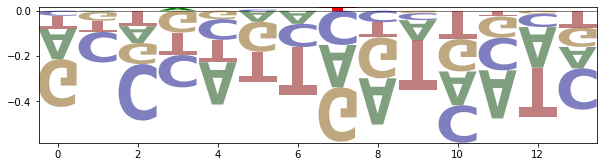

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


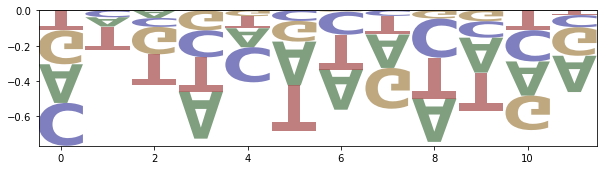


EGR1:ZeroCycle_TCAGCC40NTTC_0_0:EGR1_eDBD_2_KR_TCAGCC40NTTC
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


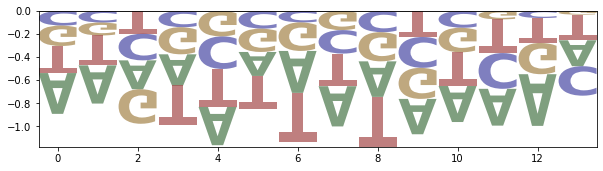

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


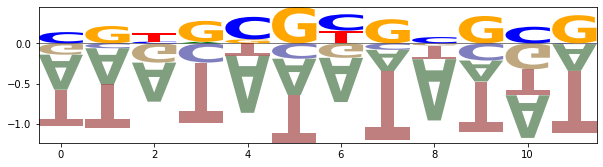


EGR1:ZeroCycle_TCCGCT40NGCG_0_0:EGR1_eDBD_2_KAN_TCCGCT40NGCG
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


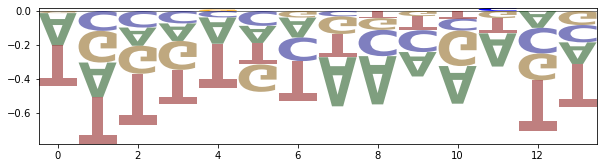

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


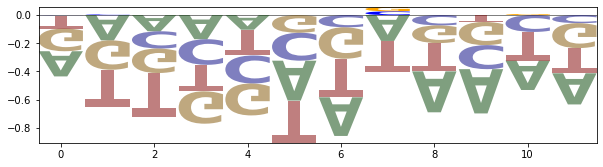


EGR1:ZeroCycle_TTGTAC40NGTA_0_0:EGR1_eDBD_2_KR_TTGTAC40NGTA
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


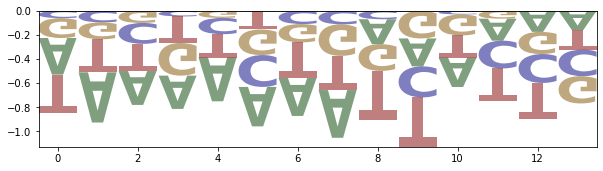

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


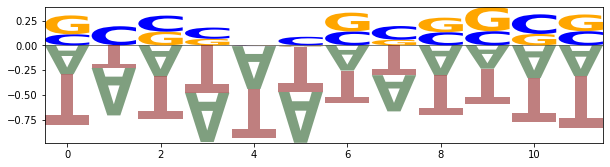


ETS1:ZeroCycle_TGTAAA20NGA_0_0:ETS1_TGTAAA20NGA_AF_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


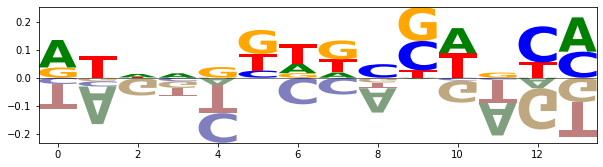

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


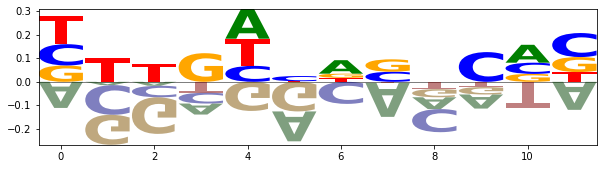


ETS1:ZeroCycle_ES0_TGTAAA20NGA_0:ETS1_TGTAAA20NGA_AF_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


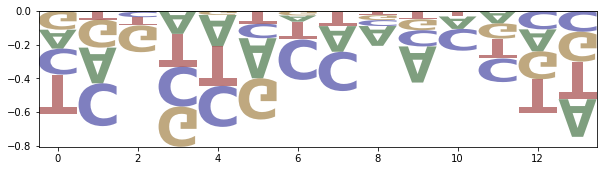

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


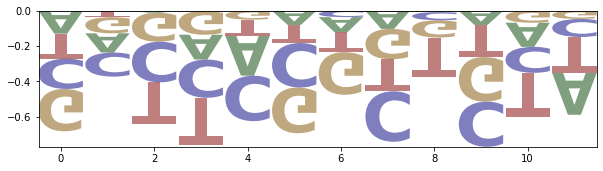


ETS1:ZeroCycle_TGTACC30NCAG_0_0:ETS1_TGTACC30NCAG_AI_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


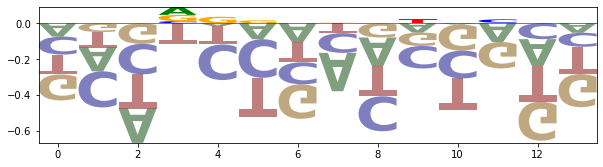

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


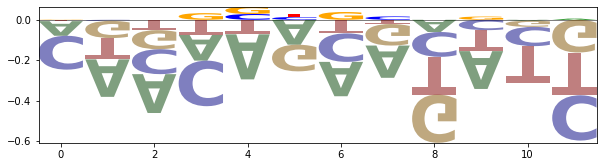


ETS1:ZeroCycle_ES0_TGTACC30NCAG_0:ETS1_TGTACC30NCAG_AI_2
0 None
1 Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)


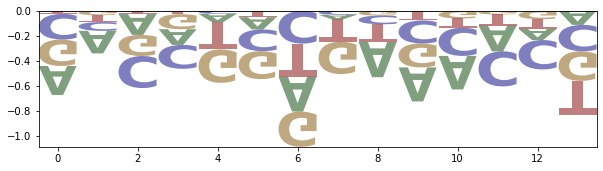

2 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)


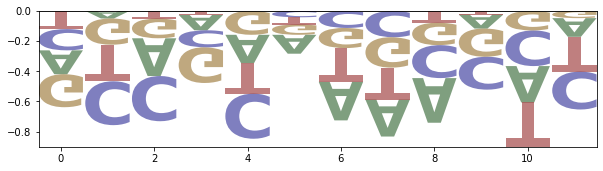

In [15]:
for k in model2_by_k:
    print(k)
    model2 = model2_by_k[k] 
    mb.pl.conv_mono(model2)
    print('')

In [19]:
#training the ETS1 model over all rounds for one more epoch in order to test get_last_loss_value()
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=1, early_stopping=-1, log_each=1)

Epoch:  1, Loss: 0.436


[0.43597027683038486]

In [20]:
mb.tl.get_last_loss_value()

0.43597027683038486